# Distribution of $3$-Selmer ranks

We computed $3$-Selmer ranks of congruent number curves using Magma. There are no theoretical results regarding their distribution. We experiment along the lines of results about $2$-Selmer groups and find some interesting patterns. 

- The parity distribution is similar to that of $2$-Selmer groups and arithmetic ranks.
- Average size is more or less constant across residue classes modulo $8$.
- Probability mass function matches with the theoretical predictions.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert the PyArrow Table to a Pandas DataFrame
df = pd.read_csv("threeselmer.csv")
df['size'] = 3 ** (df['3selmer_rank'])
df['mod8'] = df["n"] % 8
#odd_df =  df[df['mod8'].isin([1,3,5,7])].drop(columns=['2selmer_rank'])
#odd_df['group'] = odd_df['mod8'].map(lambda x: '1_3' if x in [1, 3] else '5_7')

df

,n,3selmer_rank,size,mod8
0,1,0,1,1
1,2,0,1,2
2,3,0,1,3
3,5,1,3,5
4,6,1,3,6
...,...,...,...,...
69605,112494,1,3,6
69606,112495,1,3,7
69607,112497,2,9,1
69608,112498,0,1,2


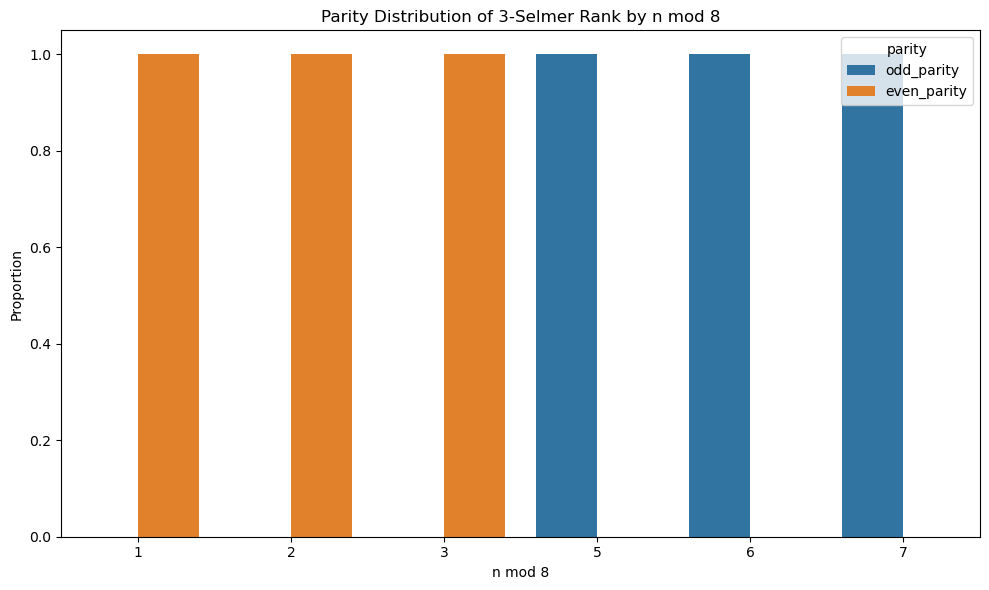

In [2]:
df['parity'] = df['3selmer_rank'] % 2

# Empirical parity and congruence distribution by mod8
summary = []

for mod8_class in sorted(df['mod8'].unique()):
    group = df[df['mod8'] == mod8_class]
    count = len(group)

    # Parity distribution
    parity_counts = group['parity'].value_counts(normalize=True).to_dict()
    odd_pct = parity_counts.get(1, 0)
    even_pct = parity_counts.get(0, 0)

    summary.append({
        'mod8': mod8_class,
        'odd_parity': odd_pct,
        'even_parity': even_pct
    })

summary_df = pd.DataFrame(summary)



#Plot: Selmer Parity by mod 8

plt.figure(figsize=(10, 6))
parity_plot = summary_df.melt(id_vars='mod8', value_vars=['odd_parity', 'even_parity'],
                              var_name='parity', value_name='percentage')
sns.barplot(data=parity_plot, x='mod8', y='percentage', hue='parity')
plt.title("Parity Distribution of 3-Selmer Rank by n mod 8")
plt.ylabel("Proportion")
plt.xlabel("n mod 8")
plt.tight_layout()
#plt.savefig("parity3s.jpeg")
plt.show()

In [3]:
import plotly.express as px
summary_data = []

for mod8_class in sorted(df['mod8'].unique()):
    group = df[df['mod8'] == mod8_class]
    total = len(group)
    odd_count = (group['parity'] == 1).sum()
    even_count = (group['parity'] == 0).sum()

    summary_data.append({
        'mod8': mod8_class,
        'total': total,
        'odd_count': odd_count,
        'odd_pct': odd_count / total if total > 0 else 0,
        'even_count': even_count,
        'even_pct': even_count / total if total > 0 else 0,
    })
summary_df = pd.DataFrame(summary_data)
# Print summary table
print("\nSummary of Parity & Congruence by n mod 8:\n")
print(summary_df.to_string(index=False))


# Count selmer ranks per mod8 class
hist_df = df.groupby(['mod8', '3selmer_rank']).size().reset_index(name='count')

# Normalize per mod8 class
hist_df['total'] = hist_df.groupby('mod8')['count'].transform('sum')
hist_df['percentage'] = hist_df['count'] / hist_df['total']


Summary of Parity & Congruence by n mod 8:

 mod8  total  odd_count  odd_pct  even_count  even_pct
    1  11594          0      0.0       11594       1.0
    2  11596          0      0.0       11596       1.0
    3  11599          0      0.0       11599       1.0
    5  11604      11604      1.0           0       0.0
    6  11607      11607      1.0           0       0.0
    7  11610      11610      1.0           0       0.0


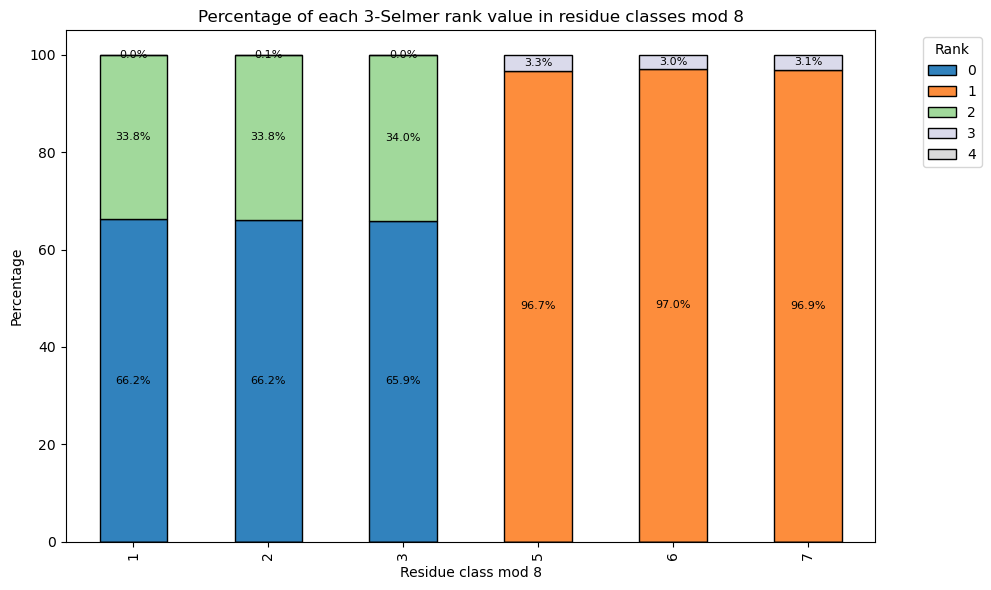

In [10]:
counts = df.groupby(['mod8', '3selmer_rank']).size().unstack(fill_value=0)

# Convert counts to percentages within each mod8 class
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot
ax = percentages.plot(kind='bar', stacked=True, figsize=(10, 6), 
                      colormap='tab20c', edgecolor='black')

plt.ylabel("Percentage")
plt.xlabel("Residue class mod 8")
plt.title("Percentage of each 3-Selmer rank value in residue classes mod 8")
plt.legend(title="Rank", bbox_to_anchor=(1.05, 1), loc='upper left')
# Add percentage labels on each segment
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}%",
                ha='center', va='center',
                fontsize=8, color='black'
            )
plt.tight_layout()
plt.savefig("3selr_dist.jpeg")
plt.show()

In [12]:
avg_size = df['size'].mean()
print("The average size of the 3-Selmer group, calculated for the entire dataset = ", avg_size)

The average size of the 3-Selmer group, calculated for the entire dataset =  3.748369487142652


          mean  count
mod8                 
1     3.715888  11594
2     3.756813  11596
3     3.757479  11599
5     3.798345  11604
6     3.711295  11607
7     3.750388  11610


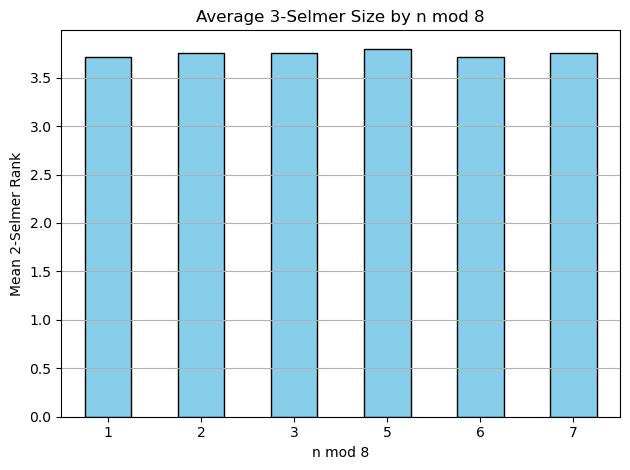

In [14]:
# Group by mod 8 residue and compute mean 2-Selmer rank and count
conditional_moments = df.groupby('mod8')['size'].agg(['mean', 'count']).sort_index()

# Display the table
print(conditional_moments)

# Plot: mean 2-Selmer rank by residue mod 8
conditional_moments['mean'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average 3-Selmer Size by n mod 8")
plt.xlabel("n mod 8")
plt.ylabel("Mean 2-Selmer Rank")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("conditional3s.jpeg")
plt.show()


In [15]:
odd_df =  df[df['mod8'].isin([1,3,5,7])].drop(columns=['3selmer_rank'])
odd_df['group'] = odd_df['mod8'].map(lambda x: '1_3' if x in [1, 3] else '5_7')

odd_df

,n,size,mod8,parity,group
0,1,1,1,0,1_3
2,3,1,3,0,1_3
3,5,3,5,1,5_7
5,7,3,7,1,5_7
7,11,1,3,0,1_3
...,...,...,...,...,...
69602,112489,9,1,0,1_3
69604,112493,3,5,1,5_7
69606,112495,3,7,1,5_7
69607,112497,9,1,0,1_3



Comparison Table:
    mod8  k  EmpiricalMean
0      1  1       3.748369
1      1  2      31.258986
2      1  3     560.356328
3      3  1       3.748369
4      3  2      31.258986
5      3  3     560.356328
6      5  1       3.748369
7      5  2      31.258986
8      5  3     560.356328
9      7  1       3.748369
10     7  2      31.258986
11     7  3     560.356328


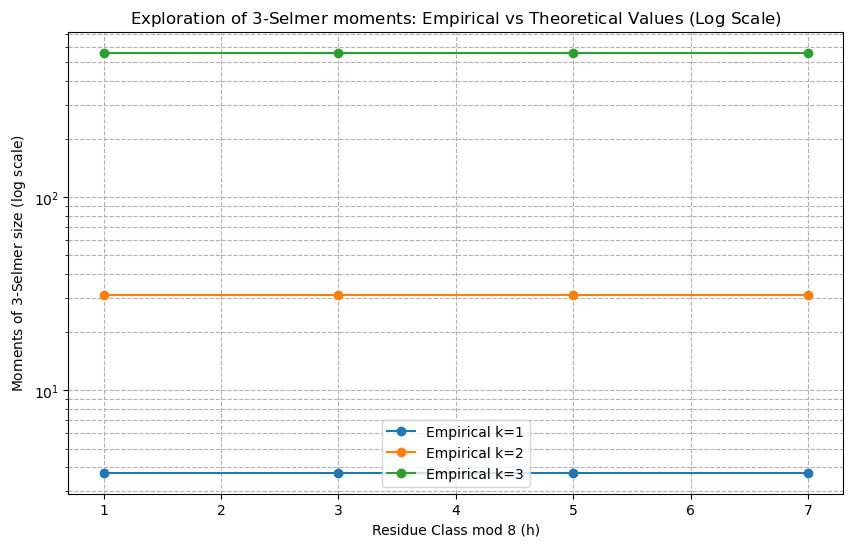

In [16]:
## Theorem 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def validate_theorem_1(odd_df, k_values=[1, 2, 3]):
    
    # Prepare comparison table
    results = []

    for h in [1, 3, 5, 7]:
        subset = odd_df[odd_df['mod8'] == h]
        size_h = len(subset)

        if size_h == 0:
            print(f"No data for residue class {h}. Skipping.")
            continue

        for k in k_values:
            empirical_mean = (df['size'] ** k ).mean()

            results.append({
                'mod8': h,
                'k': k,
                'EmpiricalMean': empirical_mean
            })

    result_df = pd.DataFrame(results)
    print("\nComparison Table:")
    print(result_df)
    return result_df




def plot_theorem1_logscale(result_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    for k in [1,2,3]:
        df_k = result_df[result_df['k'] == k]
        ax.plot(df_k['mod8'], df_k['EmpiricalMean'], 'o-', label=f'Empirical k={k}')

    ax.set_xlabel("Residue Class mod 8 (h)")
    ax.set_ylabel("Moments of $3$-Selmer size (log scale)")
    ax.set_yscale("log")
    ax.set_title("Exploration of $3$-Selmer moments: Empirical vs Theoretical Values (Log Scale)")
    ax.legend()
    ax.grid(True, which="both", linestyle="--")
    plt.savefig("sel3moments.jpeg")
    plt.show()


result_df = validate_theorem_1(odd_df, k_values=[1, 2, 3])

plot_theorem1_logscale(result_df)

In [17]:
for group in ['1_3', '5_7']:
    subset = odd_df[odd_df['group'] == group]
    freq = subset['size'].value_counts(normalize=True).sort_index()
    print(f"Empirical frequencies for group {group}:\n{freq}\n")


Empirical frequencies for group 1_3:
size
1     0.660630
9     0.339068
81    0.000302
Name: proportion, dtype: float64

Empirical frequencies for group 5_7:
size
3     0.967735
27    0.032265
Name: proportion, dtype: float64



In [18]:
for k in [1, 2, 3, 4, 5]:
    moment = (df['size'] ** k).mean()
    print(f"Empirical {k}-th moment of 2-Selmer rank: {moment:.5f}")

Empirical 1-th moment of 2-Selmer rank: 3.74837
Empirical 2-th moment of 2-Selmer rank: 31.25899
Empirical 3-th moment of 2-Selmer rank: 560.35633
Empirical 4-th moment of 2-Selmer rank: 18770.42623
Empirical 5-th moment of 2-Selmer rank: 986768.24428


In [19]:
import math
#import matplotlib.pyplot as plt

def selmer_pmf(p: int, d_max: int, N: int = 100):
    """
    Approximate Selmer probability mass function for F_p-dimension d = 0 to d_max.
    Parameters:
        p : prime
        d_max : maximum dimension to compute
        N : number of terms to truncate the infinite product
    Returns:
        List of (d, probability)
    """
    from math import prod

    # Compute the normalizing constant: prod_{j>=0} (1 + p^{-j})^{-1}
    norm = 1.0
    for j in range(N):
        norm *= 1 / (1 + p**(-j))

    result = []
    for d in range(d_max + 1):
        if d == 0:
            prob = norm
        else:
            term = prod(p / (p**j - 1) for j in range(1, d + 1))
            prob = norm * term
        result.append((d, prob))

    return result

# Example usage
p = 2
d_max = 5
pmf = selmer_pmf(p, d_max)

# Display as table
print(f"{'d':>2} | {'P(dim Sel_p = d)':>20}")
print("-" * 25)
for d, prob in pmf:
    print(f"{d:>2} | {prob:>20.8f}")

# Plotting
'''import matplotlib.pyplot as plt
d_vals, probs = zip(*pmf)
plt.bar(d_vals, probs)
plt.xlabel("Selmer Rank d")
plt.ylabel(f"Probability (p = {p})")
plt.title("Poonen–Rains Conjectured Distribution")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show() '''


 d |     P(dim Sel_p = d)
-------------------------
 0 |           0.20971122
 1 |           0.41942244
 2 |           0.27961496
 3 |           0.07988999
 4 |           0.01065200
 5 |           0.00068723


'import matplotlib.pyplot as plt\nd_vals, probs = zip(*pmf)\nplt.bar(d_vals, probs)\nplt.xlabel("Selmer Rank d")\nplt.ylabel(f"Probability (p = {p})")\nplt.title("Poonen–Rains Conjectured Distribution")\nplt.grid(True, linestyle=\'--\', alpha=0.5)\nplt.show() '

**S2r	Poonen–Rains Probability**

 0 |           0.31950229
 1 |           0.47925343
 2 |           0.17972004
 3 |           0.02073693
 4 |           0.00077763

Plotting Empirical vs. Theoretical PMF

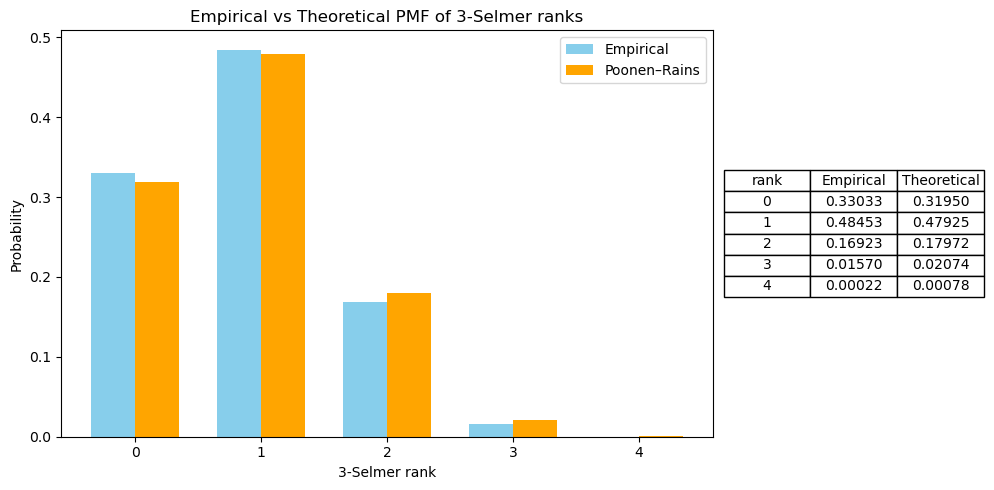

In [20]:
from matplotlib.gridspec import GridSpec

empirical_pmf = (df['3selmer_rank']).value_counts(normalize=True).sort_index()
#print("Empirical PMF of 2-Selmer Rank:")
#print(empirical_pmf)

# Truncate to common support (up to 4 or 5 is usually enough)
max_rank = min(empirical_pmf.index.max(), 4)
ranks = list(range(0, max_rank + 1))

# Fill in missing empirical probabilities with 0
empirical_probs = [empirical_pmf.get(r, 0) for r in ranks]

#print(empirical_probs)


# Theoretical Poonen–Rains probabilities (normalized for first 5 ranks)
poonen_rains_pmf = {
    0: 0.31950229,
    1: 0.47925343,
    2: 0.17972004,
    3: 0.02073693,
    4: 0.00077763
}
theoretical_probs = [poonen_rains_pmf.get(r, 0) for r in ranks]



# Create grid layout: 1 row, 2 columns (bar chart + table)
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1])
bar_width = 0.35
x = range(len(ranks))

# --- Left: Bar Chart ---
ax1 = fig.add_subplot(gs[0])

bars1 = plt.bar([i - bar_width/2 for i in x], empirical_probs, width=bar_width, label="Empirical", color='skyblue')
bars2 = plt.bar([i + bar_width/2 for i in x], theoretical_probs, width=bar_width, label="Poonen–Rains", color='orange')
#bars1 = ax1.bar(ks - width/2, empirical_probs, width=bar_width, label='Empirical', color='skyblue')
#bars2 = ax1.bar(ks + width/2, theoretical_probs, width, label='Poonen–Rains', color='orange')

ax1.set_xlabel("3-Selmer rank")
ax1.set_ylabel("Probability")
ax1.set_title("Empirical vs Theoretical PMF of 3-Selmer ranks")
ax1.set_xticks(x)
#ax1.set_xticklabels([f'$k={k}$' for k in ks])
ax1.legend()

# --- Right: Table ---
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Hide axis

# Build table data
cell_text = []
for i, k in enumerate(x):
    cell_text.append([f'${k}$', f'{empirical_probs[i]:.5f}', f'{theoretical_probs[i]:.5f}'])

# Draw table
table = ax2.table(
    cellText=cell_text,
    colLabels=["rank", "Empirical", "Theoretical"],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.tight_layout()
plt.savefig("prpmf3s.jpeg")
plt.show()

**Total Variation Distance (TVD)**

To quantify the match, use the total variation distance between the empirical and theoretical distributions: A small TVD (e.g., < 0.1) suggests strong agreement with theory.

In [12]:
tvd = 0.5 * sum(abs(emp - theo) for emp, theo in zip(empirical_probs, theoretical_probs))
print(f"Total Variation Distance (TVD): {tvd:.4f}")

Total Variation Distance (TVD): 0.0163


Moment          Empirical    Theoretical
E[r^1]           3.748369       3.999971
E[r^2]          31.258986      39.978591
E[r^3]         560.356328    1104.028176


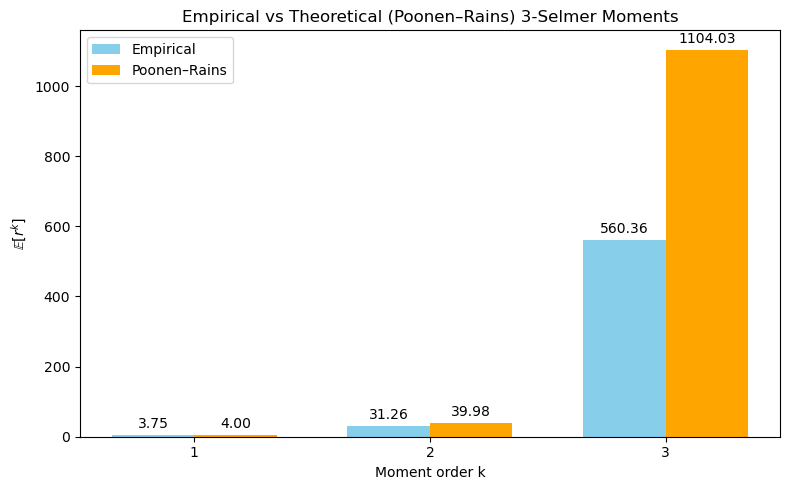

In [21]:
#import pandas as pd
import numpy as np


# Step 1: Compute empirical moments
empirical_moments = {}

for k in range(1, 4):
    empirical_moments[k] = ((df['size']) ** k).mean()

# Step 2: Define Poonen–Rains PMF (truncated at rank 5)
poonen_rains_pmf = { 0 : 0.31950229, 1 : 0.47925343, 2 : 0.17972004, 3 : 0.02073693, 4 : 0.00077763, 5 : 0.00000964}

# Step 3: Compute theoretical moments
theoretical_moments = {}
for k in range(1, 4):
    moment = sum((3 ** (r*k)) * prob for r, prob in poonen_rains_pmf.items())
    theoretical_moments[k] = moment

# Step 4: Print comparison
print(f"{'Moment':<10}{'Empirical':>15}{'Theoretical':>15}")
for k in range(1, 4):
    print(f"{'E[r^'+str(k)+']':<10}{empirical_moments[k]:>15.6f}{theoretical_moments[k]:>15.6f}")

#df

ks = np.arange(1,4)

empirical_vals = [empirical_moments[k] for k in ks]
theoretical_vals = [theoretical_moments[k] for k in ks]
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(ks - width/2, empirical_vals, width, label='Empirical', color='skyblue')
bars2 = ax.bar(ks + width/2, theoretical_vals, width, label='Poonen–Rains', color='orange')
ax.set_xlabel("Moment order k")
ax.set_ylabel(r"$\mathbb{E}[r^k]$")
ax.set_title("Empirical vs Theoretical (Poonen–Rains) 3-Selmer Moments")
ax.set_xticks(ks)
ax.legend()
# Optional: Add values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.tight_layout()
plt.savefig("prmoments3s.jpeg")
plt.show()

The plot of the abvove comparison

Empirical Moments vs. number growth

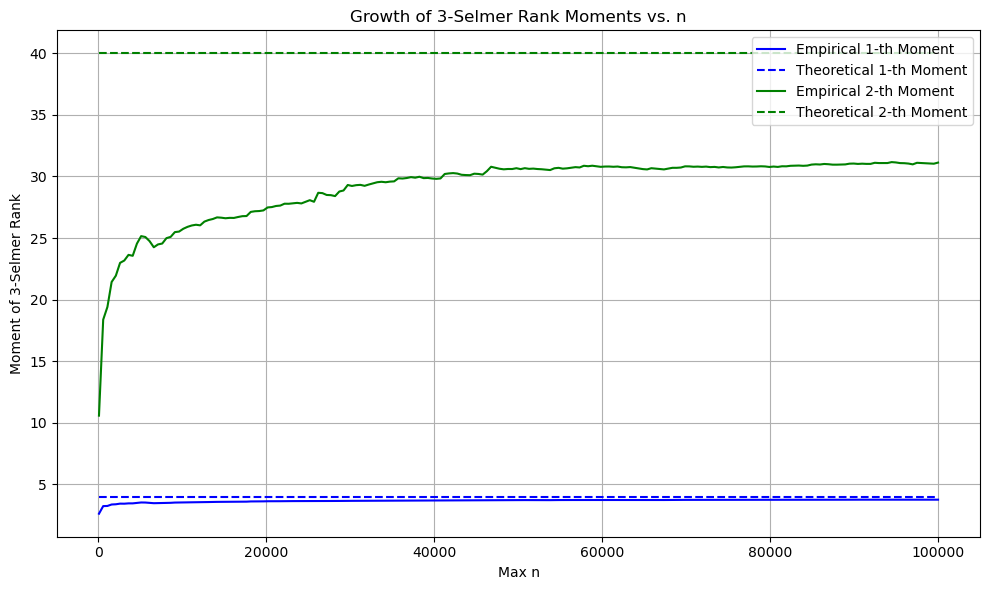

In [22]:
import numpy as np

# Define sample points X (increasing values of n)
X_values = np.linspace(100, 1_00_000, 200, dtype=int)

# Choose which moments to compute
moment_orders = [1, 2]
moment_data = {k: [] for k in moment_orders}

# Compute moments up to each X
for X in X_values:
    subset = df[df['n'] <= X]
    for k in moment_orders:
        moment_k = ((subset['size']) ** k).mean()
        moment_data[k].append(moment_k)
    #print(moment_data[1])

# Plot each moment
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
theoretical_moments = {
    1: 4.0,
    2: 40.0,
    3: 1104.0  # From Poonen–Rains model for 2-Selmer RECHECK VALUES
}

for i, k in enumerate(moment_orders):
    plt.plot(X_values, moment_data[k], label=f"Empirical {k}-th Moment", color=colors[i])
    if k in theoretical_moments:
        plt.hlines(theoretical_moments[k], X_values[0], X_values[-1], 
                   color=colors[i], linestyle='--', label=f"Theoretical {k}-th Moment")

plt.title("Growth of 3-Selmer Rank Moments vs. n")
plt.xlabel("Max n")
plt.ylabel("Moment of 3-Selmer Rank")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()